In [1]:
import os
from copy import deepcopy

import random

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [2]:
df_X = pd.read_csv("./data/x_train.csv", header=None)
df_y = pd.read_csv("./data/y_train.csv", header=None)

In [3]:
np_X = df_X.to_numpy()
np_y = df_y.to_numpy()

Поиск зависимостей в данных

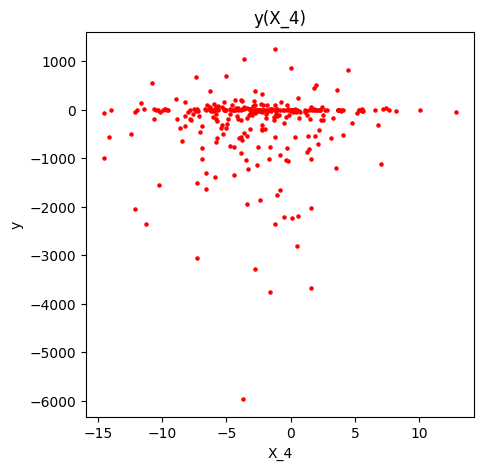

In [4]:
# Рассматриваем X_4
i_X = 4
# Построим y(X_4)
plt.figure(figsize=(5, 5))
plt.title(f"y(X_{i_X})")
plt.xlabel(f"X_{i_X}")
plt.ylabel(f"y")
plt.scatter(np_X[:, i_X], np_y, s=5, color=(1., 0., 0.))

Отметим важную особенность: есть группа точек, которые имеют примерно схожее значение по y (близкое к медианному)

Остальные точки имеют сильно различающееся y.

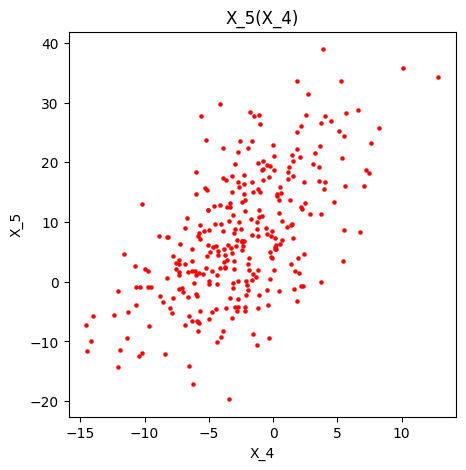

In [5]:
# Рассматриваем X_5
j_X = 5
# Построим X_5(X_4)
plt.figure(figsize=(5, 5))
plt.title(f"X_{j_X}(X_{i_X})")
plt.xlabel(f"X_{i_X}")
plt.ylabel(f"X_{j_X}")
plt.scatter(np_X[:, i_X], np_X[:, j_X], s=5, color=(1., 0., 0.))

In [6]:
# Размер валидационной выборки - 25 %
X_train, X_val, y_train, y_val = train_test_split(np_X, np_y, test_size=0.25, random_state=42)

Линейная модель

MSE: 159311.24741744174


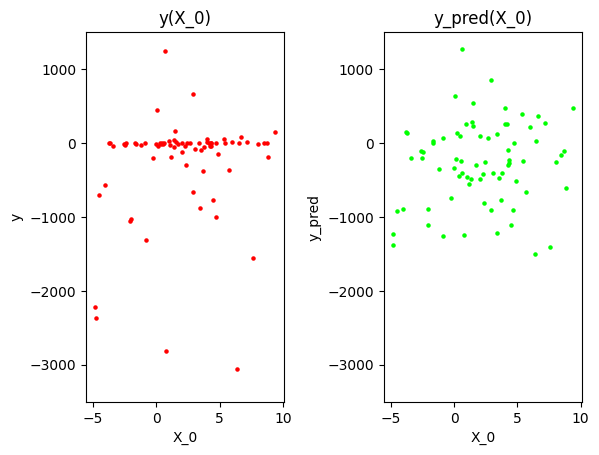

In [7]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
print(f"MSE: {mean_squared_error(y_val, linear_model.predict(X_val))}")
i_X = 0
y_min, y_max = -3500, 1500
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(1, 2, 1)
plt.title(f"y(X_{i_X})")
plt.xlabel(f"X_{i_X}")
plt.ylabel(f"y")
plt.ylim([y_min, y_max])
plt.scatter(X_val[:, i_X], y_val, s=5, color=(1., 0., 0.))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(1, 2, 2)
plt.title(f"y_pred(X_{i_X})")
plt.xlabel(f"X_{i_X}")
plt.ylabel(f"y_pred")
plt.ylim([y_min, y_max])
plt.scatter(X_val[:, i_X], linear_model.predict(X_val), s=5, color=(0., 1., 0.))

Решение, использующее одну нейронную сеть для решения задачи регрессии напрямую

In [31]:
class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return torch.tensor(self.X[i]).float(), torch.tensor(self.y[i]).float()

In [ ]:
class NNRegression:
    def __init__(self, n_hidden=128, n_hidden_layers=2, lr=1e-3, n_epochs=200, batch_size=32, sigmoid_rate=0):
        self.n_hidden = n_hidden
        self.n_hidden_layers = n_hidden_layers
        self.lr = lr
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        # sigmoid_rate - доля sigmoid среди функций активации
        self.sigmoid_rate = sigmoid_rate
        self.model = None
        self.train_loss = None
        self.val_loss = None
    
    def fit(self, X_train, y_train, X_val, y_val):
        n_val_X = X_train.shape[-1]
        n_val_y = y_train.shape[-1]

        lawyers = [nn.Linear(n_val_X, self.n_hidden), nn.ReLU()]
        for i in range(self.n_hidden_layers):
            lawyers.append(nn.Linear(self.n_hidden, self.n_hidden))
            if random.random() < self.sigmoid_rate:
                lawyers.append(nn.Sigmoid())
            else:
                lawyers.append(nn.ReLU())
        lawyers.append(nn.Linear(self.n_hidden, n_val_y))
        self.model = nn.Sequential(*lawyers)
        
        optim = Adam(self.model.parameters(), lr=self.lr)
        dataset = RegressionDataset(X_train, y_train)
        dataloader = DataLoader(dataset, shuffle=True, batch_size=self.batch_size)
        self.train_loss = []

        val_dataset = RegressionDataset(X_val, y_val)
        val_dataloader = DataLoader(val_dataset, batch_size=self.batch_size)
        self.val_loss = []

        best_model = None
        best_num_epoch = None
        best_val_loss = None
        
        for epoch in range(1, self.n_epochs + 1):
            losses = []
            for x_batch, y_batch in dataloader:
                y_pred = self.model(x_batch)
                loss = F.mse_loss(y_pred, y_batch)
                optim.zero_grad()
                loss.backward()
                optim.step()
                losses.append(loss.detach().item())
            self.train_loss.append(np.mean(losses))

            with torch.no_grad():
                losses = []
                for x_batch, y_batch in val_dataloader:
                    y_pred = self.model(x_batch)
                    loss = F.mse_loss(y_pred, y_batch)
                    losses.append(loss.detach().item())
                self.val_loss.append(np.mean(losses))
            
            if best_val_loss == None or best_val_loss > self.val_loss[-1]:
                best_val_loss = self.val_loss[-1]
                best_num_epoch = epoch
                best_model = deepcopy(self.model)
            if epoch % 100 == 0:
                # Вывод сведений о процессе обучения
                print(f"Epoch {epoch}, loss {round(self.val_loss[-1])}")
        self.model = deepcopy(best_model)
        # Лучшая модель
        print(f"Best loss was at {best_num_epoch} epoch: {round(best_val_loss)}")

    def predict(self, X):
        with torch.no_grad():
            X = torch.tensor(X).float()
            y = self.model(X).numpy()
            return y

In [ ]:
# Гиперпараметры
n_hidden = 13
n_hidden_layers = 3
lr = 3e-4
n_epochs = 2500
batch_size = 2
sigmoid_rate = 0.4

In [ ]:
model = NNRegression(n_hidden=n_hidden, n_hidden_layers=n_hidden_layers, lr=lr, n_epochs=n_epochs, batch_size=batch_size, sigmoid_rate=sigmoid_rate)
model.fit(X_train, y_train, X_val, y_val)

Epoch 100, loss 121678
Epoch 200, loss 92586
Epoch 300, loss 83934
Epoch 400, loss 85511
Epoch 500, loss 78883
Epoch 600, loss 74669
Epoch 700, loss 79475
Epoch 800, loss 80708
Epoch 900, loss 71279
Epoch 1000, loss 73230
Epoch 1100, loss 75033
Epoch 1200, loss 67574
Epoch 1300, loss 75478
Epoch 1400, loss 73612
Epoch 1500, loss 72916
Epoch 1600, loss 72955
Epoch 1700, loss 71582
Epoch 1800, loss 73672
Epoch 1900, loss 70265
Epoch 2000, loss 77555
Epoch 2100, loss 70854
Epoch 2200, loss 72127
Epoch 2300, loss 57559
Epoch 2400, loss 68881
Epoch 2500, loss 70721
Best loss was at 2300 epoch: 57559


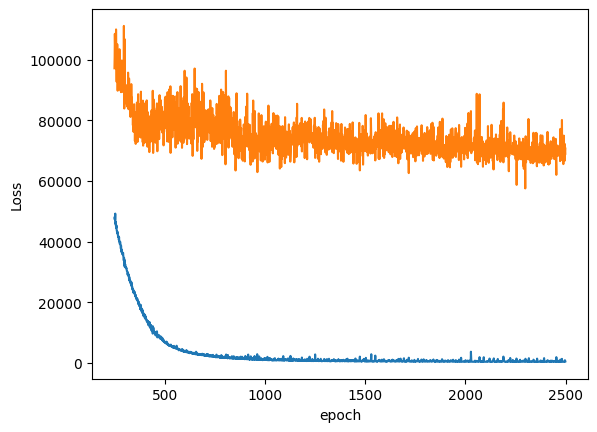

In [ ]:
# График функции потерь на тренировочной и валидационной выборках

# Начинаем строить график, начиная с конкретной эпохи
cut_start = 0.1
# Начинаем строить график, заканчивая конкретной эпохой
cut_end = 0
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(np.arange(int(len(model.train_loss) * cut_start), len(model.train_loss) - int(len(model.train_loss) * cut_end)), 
         model.train_loss[int(len(model.train_loss) * cut_start):len(model.train_loss) - int(len(model.train_loss) * cut_end)])
plt.plot(np.arange(int(len(model.val_loss) * cut_start), len(model.val_loss) - int(len(model.val_loss) * cut_end)), 
         model.val_loss[int(len(model.val_loss) * cut_start):len(model.val_loss) - int(len(model.val_loss) * cut_end)])

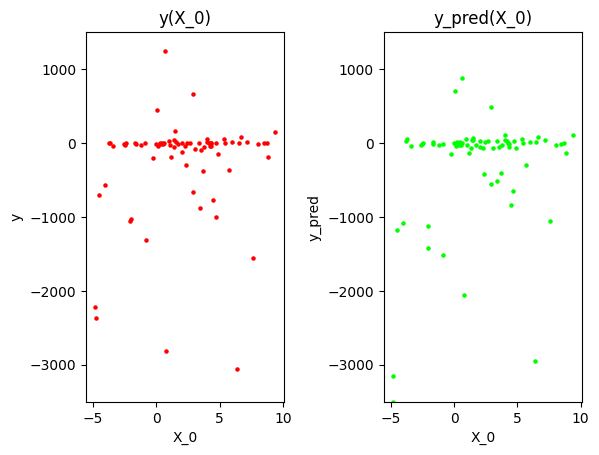

In [ ]:
# Сравним предсказанные и истинные данные на валидационной выборке

i_X = 0
y_min, y_max = -3500, 1500
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(1, 2, 1)
plt.title(f"y(X_{i_X})")
plt.xlabel(f"X_{i_X}")
plt.ylabel(f"y")
plt.ylim([y_min, y_max])
plt.scatter(X_val[:, i_X], y_val, s=5, color=(1., 0., 0.))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.subplot(1, 2, 2)
plt.title(f"y_pred(X_{i_X})")
plt.xlabel(f"X_{i_X}")
plt.ylabel(f"y_pred")
plt.ylim([y_min, y_max])
plt.scatter(X_val[:, i_X], model.predict(X_val), s=5, color=(0., 1., 0.))

In [37]:
print(f"MSE: {mean_squared_error(y_val, model.predict(X_val))}")

MSE: 56659.170294460295


In [ ]:
df_X_test = pd.read_csv("./data/x_test.csv", header=None)
np_X_test = df_X_test.to_numpy()
np_y_test = model.predict(np_X_test)
df_y_test = pd.DataFrame(np_y_test)

cur = 0
for file_name in os.listdir("./submissions"):
    if file_name.startswith("submission") and file_name.endswith('.csv') and file_name != "submission_example.csv":
        cur += 1
# Запись предсказаний в файл .csv
df_y_test.to_csv(f"./submissions/submission_{cur}.csv", header=False, index=False)
print(f"File saved: ./submissions/submission_{cur}.csv")

# Запись информации о гиперпараметрах в файл info
with open("info.txt", 'a') as f:
    print(f"{cur}. n_hidden = {n_hidden}, n_hidden_layers = {n_hidden_layers}, lr = {lr}, n_epochs = {n_epochs}, batch_size = {batch_size}, sigmoid_rate = {sigmoid_rate}, MSE = {round(mean_squared_error(y_val, model.predict(X_val)))}", file=f)


File saved: ./submissions/submission_22.csv
